# Linear transformations with images
In this module we will work with linearly aligning images.  We'll apply transformations to images, and estimate optimal transformations.  Here problems will be nonlinear, and we'll need to use iterative methods.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import os # for file paths
import summerschool as ss
import nibabel as nib # for loading many common neuroimage formats
import scipy.interpolate as spi # use interpolation to deform images

## Load some data

In [3]:
fname = os.path.join('mouse_images','PMD2052_orig_target_STS_clean.img')
img = nib.load(fname)
# load the image
I = img.get_data()[:,:,:,0] # note last axes is time, we'd like to remove it
# standardize
I = (I - np.mean(I))/np.std(I)
# downsample so it can run on people's laptops
down = 3
I = ss.downsample_image(I,down)

# set up a domain, a grid of points describing the locations of each voxel
nx = I.shape # number of voxels
dx = img.header['pixdim'][1:4]*down # size of each voxel
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]

# lets define the origin to be in the middle of our image
# linear transformations will be more reasonable this way
# i.e. we'll rotate around the middle, instead of rotating around a corner
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

<IPython.core.display.Javascript object>


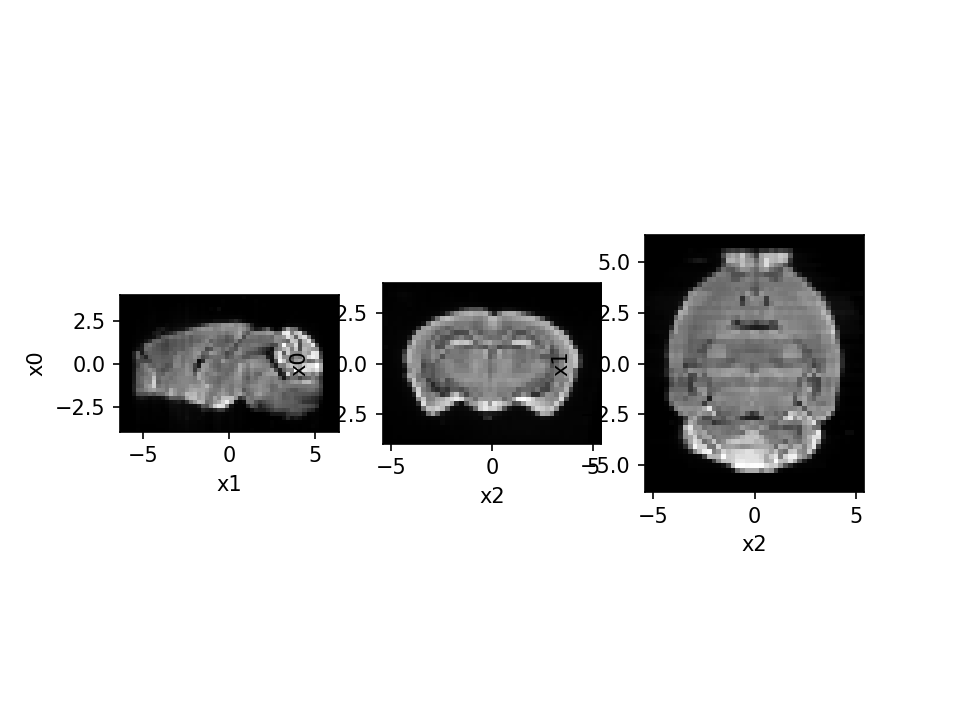

In [4]:
# this function will show 3 orthogonal slices through the mouse image
ss.imshow_slices(x0,x1,x2,I)

## Transformations act on images through their inverse

A simple example is to consider shifting a function in 1D.  If $f(x)$ is a function that we want to translate to the right by $T$, we translate it by $f(x - T)$ (NOT $f(x+T)$).  Here $-T$ is the inverse of $+T$.  

In general, if we want to transform a function with a transformation $\varphi$, we use $f(x) \mapsto f(\varphi^{-1}(x))$.

### Explicit example in 2D

We will consider a simple 2x2 image and the effect of rotation.  If you want to rotate your image clockwise, you must rotate your coordinates counterclockwise.  This will be derived and illustrated in the lab.


## Images are deformed by sampling them at new points: interpolation

How do we evaluate $I(\varphi^{-1}(x))$ on a computer?  We need to define the grid that $I$ is sampled on.  Transform the grid using $\varphi^{-1}$.  Then resample $I$ at the new points defined by this transformed grid.

This resampling is known as interpolation.  Most numerical libaries have built in functions for interpolation, including scipy.

In [6]:
# set some arguments that will be used for interpolation with a dictionary
interp_args = {
    'method':'linear', # this says how we'd like to do interpolation, linear is fast and smooth
    'bounds_error':False, # if we try to sample outside the image, do not raise an error    
    'fill_value':None # if we try to sample outside the image, we'll return the nearest pixel value
}

In [7]:
# A 2D example image and a grid defining its sample points
I2d = np.array(I[:,:,I.shape[-1]//2])
X02d = X0[:,:,0]
X12d = X1[:,:,0]

<IPython.core.display.Javascript object>


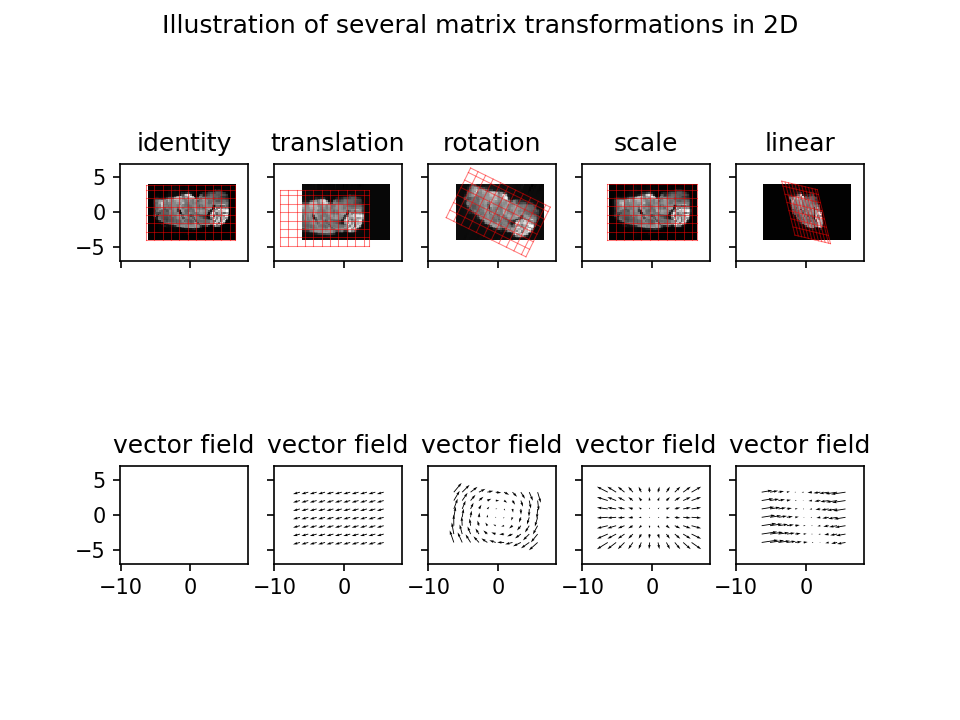

In [16]:
# make a figure
nplots = 5
f,ax = plt.subplots(2, nplots, sharex=True, sharey=True)
for i in range(nplots):
    ax_ = ax[:,i]
    # choose a transformation
    if i == 0:
        A = np.eye(3)
        titlestring = 'identity'
    elif i == 1:
        T = np.random.randn(2)*2.0
        A = np.array([[1,0,T[0]],[0,1,T[1]],[0,0,1]])
        titlestring = 'translation'
    elif i == 2:
        theta = np.random.rand()*2.0*np.pi/6.0
        A = np.eye(3)
        A[:2,:2]= [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
        titlestring = 'rotation'
    elif i==3:
        s = np.random.randn()*0.1 + 1.0
        A = np.eye(3)
        A[:2,:2] = np.eye(2)*s
        titlestring = 'scale'
    elif i == 4:
        A = np.eye(3)
        A[:2,:2] += np.random.randn(2,2)*0.2
        titlestring = 'linear' 
    
    # make a transformed grid
    # to move the points in the grid we use the forward transformation A
    AX0 = A[0,0]*X02d + A[0,1]*X12d + A[0,2]
    AX1 = A[1,0]*X02d + A[1,1]*X12d + A[1,2]
    stride = 5
    ss.plot_grid(AX1, AX0, ax=ax_[0], 
                 rstride=stride, cstride=stride,
                 color='r', linewidth=0.5, alpha=0.5)
    
    # make a transformed image
    # to transform the image we use the inverse transformatoin A^{-1}
    B = np.linalg.inv(A)
    X0s = B[0,0]*X02d + B[0,1]*X12d + B[0,2]
    X1s = B[1,0]*X02d + B[1,1]*X12d + B[1,2]
    
    # we use the built in interpolation function.  
    # 1. we input our original grid points as a list of 1D vectors
    # 2. then input our original image
    # 3. then input our transformed grid points to resample the image at
    # Note that we need to "stack" this input into a 3D array, 
    # where the first slice is the deformed X grid, and the second slice 
    # is the deformed Y grid.
    # 4. Last we input our interpolation options dictionary using "**" for "unpacking"
    AI = spi.interpn([x0,x1],I2d,np.stack([X0s,X1s],axis=-1),**interp_args)
    ax_[0].imshow(AI, cmap='gray', 
                  extent=[x1[1],x1[-1],x0[0],x0[-1]], origin='lower') # make sure you set extent and origin!
    
    ax_[0].set_aspect('equal')
    ax_[0].set_title(titlestring)

    # let's show the vector field
    ax_[1].quiver(X12d[::stride,::stride], X02d[::stride,::stride], 
                  AX1[::stride,::stride]-X12d[::stride,::stride], 
                  AX0[::stride,::stride]-X02d[::stride,::stride])
    ax_[1].set_aspect('equal')
    ax_[1].set_title('vector field')
f.suptitle('Illustration of several matrix transformations in 2D')

## Now we'll show an example transformation in 3D

<IPython.core.display.Javascript object>


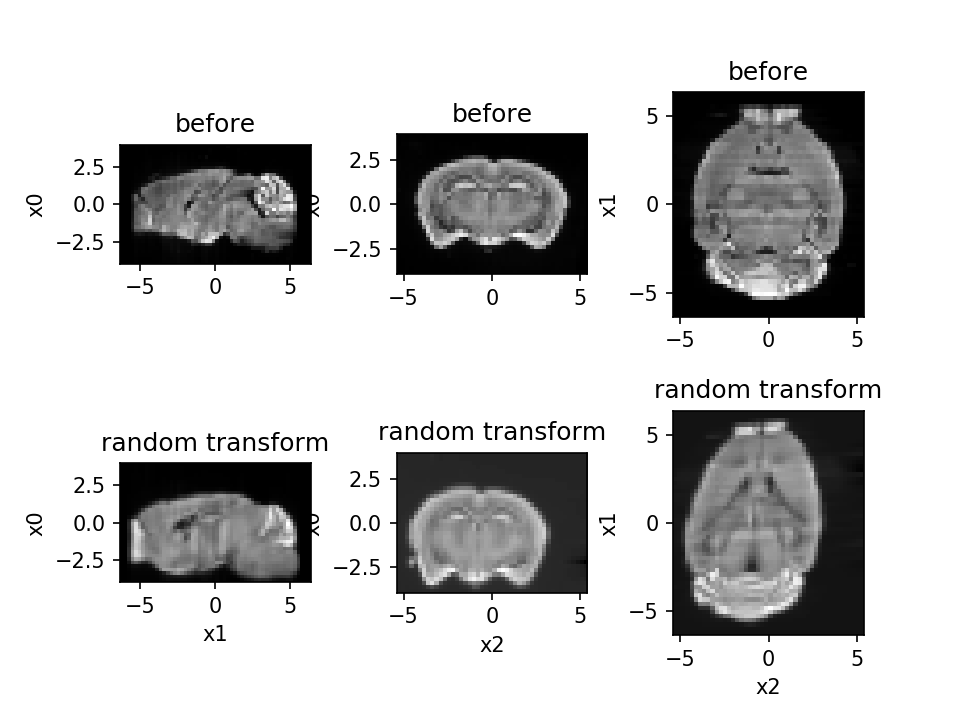

In [19]:
# construct a transformation
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation
A[:3,-1] += np.random.randn(3)*1.0 # a random shift
# generate the grid points that are transformed by inputs
def sample_points_from_affine(X0,X1,X2,A):
    # find its inverse, using homogeneous coordinates
    B = np.linalg.inv(A)
    # get the sample points by matrix multiplication
    X0s = B[0,0]*X0 + B[0,1]*X1 + B[0,2]*X2 + B[0,3]
    X1s = B[1,0]*X0 + B[1,1]*X1 + B[1,2]*X2 + B[1,3]
    X2s = B[2,0]*X0 + B[2,1]*X1 + B[2,2]*X2 + B[2,3]
    return X0s,X1s,X2s    
# this is also defined in the summer school module
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
AI = spi.interpn(
    [x0,x1,x2], # this labels where in space each voxel is
    I, # this says the intensity of our image at each voxel
    np.stack([X0s,X1s,X2s],axis=-1), # this says where we'd like to evaluate the image
    **interp_args # some more arguments that we defined above
)

# now draw it
f,ax=plt.subplots(2,3)
plt.subplots_adjust(wspace=0.45,hspace=0.35)
ss.imshow_slices(x0,x1,x2,I,ax[0])
for a in ax[0]: 
    a.set_title('before')
    a.set_xlabel('')
ss.imshow_slices(x0,x1,x2,AI,ax[1])
for a in ax[1]: a.set_title('random transform')
Irandom = AI

## Computing optimal transformations
As with points, we will write down a sum of square error cost
\begin{align*}
E(A) = \int_X \frac{1}{2}(I(A^{-1}x) - J(x))^2 dx
\end{align*}

As in the point set case we'll take it's gradient with respect to $A$.  However, since this problem is nonlinear, we will not be able to explicitly solve for $A$ by setting the result to 0.  Instead, we'll iteratively make small improvements to our estimate of $A$ by taking steps in the negative of the gradient direction.  This approach to optimization is widely used and is called gradient descent.


#### Optimizing over translation
Let's first consider a simpler problem involving translation $T$ only.  Our square error cost will be 

\begin{align*}
E(T) = \int_X \frac{1}{2}(I(x - T) - J(x))^2 dx
\end{align*}

We'll compute directional derivatives in the direction of $\delta T$, and use this to derive the gradient vector.  We use the fact that
\begin{align*}
\frac{d}{d\epsilon}E(T + \epsilon \delta T)\bigg|_{\epsilon} &= (\nabla_T E) ^T \delta A
\end{align*}
This is just the definition of the directional derivative.  It is equal to the gradient dot the direction.

We are interested in the left hand side, which is just a derivative of a function with respect to a single scalar variable.  We will use the chain rule
\begin{align*}.
\frac{d}{d\epsilon} E(T + \epsilon \delta T)\bigg|_{\epsilon = 0} &= \frac{d}{d\epsilon} \int_X \frac{1}{2}(I(x - T  \epsilon \delta T) - J(x))^2 dx \bigg|_{\epsilon = 0}\\
&= \int -[I(x - T) - J(x)] D I(x-T) dx \delta T
\end{align*}
Note that $DI$ is the image gradient as a 1x3 row vector, and $\nabla I$ the image gradient as a 3x1 column vector.

We are free to choose $\delta T$ in whatever way we want, and taking it as each element of a basis gives us the gradient
\begin{align*}
\nabla E(T) &= \int -[I(x-T) - J(x)]\nabla I(x-T)dx
\end{align*}

A gradient descent algorithm would then be to choose an initial guess for $T$, choose a small step size $\epsilon$, and repeatedly update by
\begin{align*}
T \mapsto T - \epsilon \nabla_T E(T) = T - \epsilon \int -[I(x-T) - J(x)]\nabla I(x-T) dx
\end{align*}


#### Optimizing over affine
Now we're ready to return to the affine transformation $A$.  This derivation is more challenging, you may want to skip it and just use the final result.

Since $A$ is a matrix, we'll consider an arbitrary perturbation to $A$, $A\mapsto A + \epsilon \delta A$, and take the gradient with respect to $\epsilon$ for any perturbation.
\begin{align*}
E(A + \epsilon \delta A) = \int_X \frac{1}{2}(I( (A + \epsilon \delta A)^{-1}x) - J(x))^2 dx
\end{align*}
We will use the fact that
\begin{align}
\frac{d}{d\epsilon}E(A + \epsilon \delta A) \bigg|_{\epsilon = 0} = \text{trace} \nabla E^T \delta A
\end{align}
This is just the definition of the directional derivative as the gradient dot the direction.

We are interested in the left hand side, which is just a derivative of a function with respect to a single scalar variable.  Let's consider this expression using the chain rule, first consider the square term
\begin{align*}
\frac{d}{d\epsilon}E(A + \epsilon \delta A) \bigg|_{\epsilon = 0} &= \int_X (I((A + \epsilon \delta A)^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
&=\int_X (I(A^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
\end{align*}
Note that $DI$ is the image gradient as a 1x3 row vector, and $\nabla I$ the image gradient as a 3x1 column vector.

Now consider the image
\begin{align*}
&= \int_X (I(A^{-1}x) - J(x))  DI((A + \epsilon \delta A)^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}x dx \bigg|_{\epsilon = 0}\\
&= \int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}\bigg|_{\epsilon = 0} x dx \\
\end{align*}
Now the final term depends on taking the derivative of the inverse of a matrix. We can use the matrix by scalar identity, $\frac{d}{dt}M^{-1}(t) = - M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t)$ https://en.wikipedia.org/wiki/Matrix_calculus#Matrix-by-scalar_identities .

Plugging this in with $\epsilon = 0$ gives the result
\begin{align*}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0} = -\int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) A^{-1}\delta A A^{-1} x dx 
\end{align*}
We can simplify this by recalling that $D[I(A^{-1}x)] = DI(A^{-1}x)A^{-1}$, giving
\begin{align*}
= -\int_X (I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx 
\end{align*}
Finally to work out the gradient with respect to $A$, we have to write this expression as a gradient, dot $\delta A$.  Taking the dot product on matrices using the trace gives
\begin{align*}
&= -\int_X \text{trace}(I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx \\
&= -\int_X \text{trace}A^{-1} x (I(A^{-1}x) - J(x))  D[I(A^{-1}x)] dx \delta A
\end{align*}
which gives a gradient of 
\begin{align*}
\nabla_A E &= -\int_X (I(A^{-1}x)-J) \nabla[I(A^{-1}x)](A^{-1}x)^Tdx
\end{align*}


#### Results of affine gradient calculation

The above derivation gives a gradient of 
\begin{align*}
\nabla_A E &= -\int_X (I(A^{-1}x)-J) \nabla[I(A^{-1}x)](A^{-1}x)^Tdx
\end{align*}

A gradient descent algorithm would then be to choose an initial guess for $T$, choose a small step size $\epsilon$, and repeatedly update by
\begin{align*}
A \mapsto A - \epsilon \nabla_A E(A) = T - \epsilon \int_X -(I(A^{-1}x)-J) \nabla[I(A^{-1}x)](A^{-1}x)^T dx
\end{align*}

We implement this below.

<IPython.core.display.Javascript object>


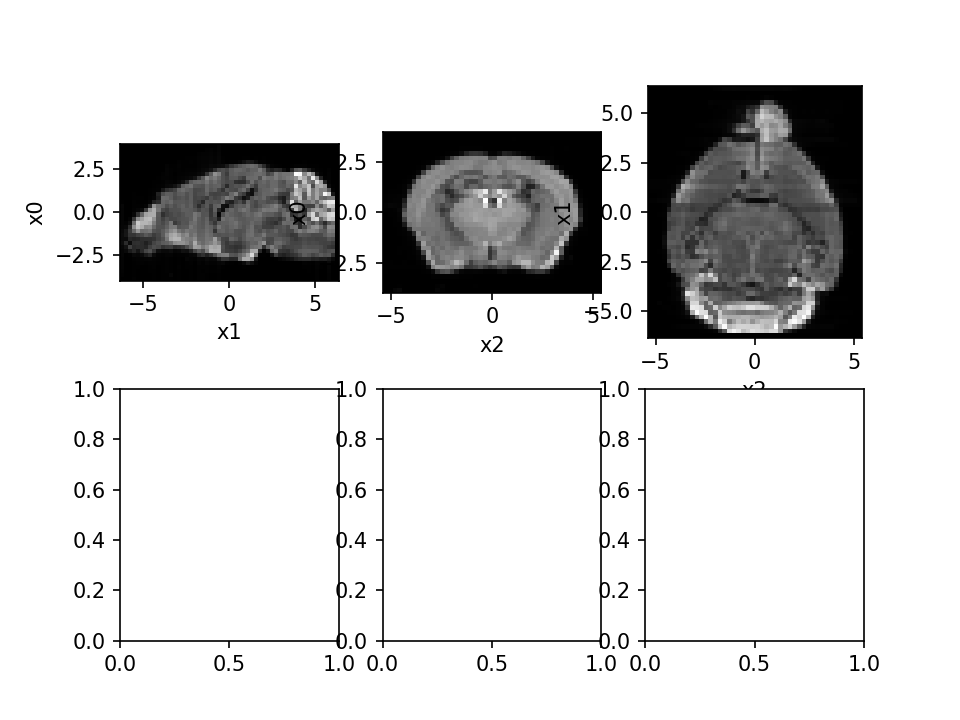

' '

In [20]:
# load a second image to map to
fname = os.path.join('mouse_images','PMD3097_orig_target_STS_clean.img')
img = nib.load(fname)
J = img.get_data()[:,:,:,0] # note last axes is time, we'd like to remove it
J = (J - np.mean(J))/np.std(J)
J = ss.downsample_image(J,down)
f,ax = plt.subplots(2,3)
ss.imshow_slices(x0,x1,x2,J,ax[0])
'''
# note that the human MRI images in this repository have already been affine aligned into MNI space
# let's add a small affine transformation and then try to recover it
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation
A[:3,-1] += np.random.randn(3)*2.0 # a random shift
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
J = spi.interpn([x0,x1,x2],J,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
ss.imshow_slices(x0,x1,x2,J,ax[1])
'''
' '

<IPython.core.display.Javascript object>


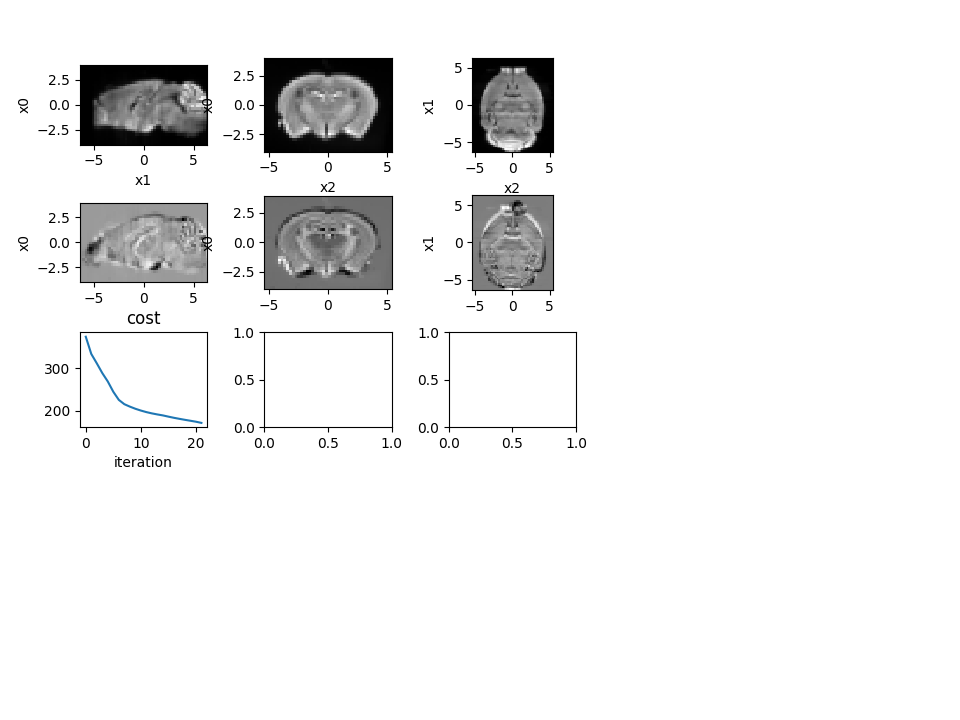

In [ ]:
# now optimize over affine transformations

# initialize a transformation
A = np.eye(4)
# choose a gradient descent step size
# note that the linear part (L) and the translation part (T) often need to be on very different scales
# for human
epsilonL = 1.0e-12
epsilonT = 1.0e-9
# for mouse, standardized data
epsilonL = 3.0e-5
epsilonT = 3.0e-4
# number of iterations of optimization
niter = 25

# initialize some variables we'll display at every iteration
EAll = [] # the energy, for plotting
f,ax = plt.subplots(3,3) # a figure for plotting
plt.subplots_adjust(wspace=0.45,hspace=0.45) # make the figure have a nicer layout
for it in range(niter):
    # find the deformed image, by deforming the grid with the inverse, and using interpolation
    X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
    AI = spi.interpn([x0,x1,x2],I,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
    
    # visualize it, we show the deforming atlas on the first row
    ss.imshow_slices(x0,x1,x2,AI,ax[0])
    
    # get the error
    err = AI-J
    
    # we show the error on the second row
    ss.imshow_slices(x0,x1,x2,err,ax[1])
    for a in ax[1]: a.set_xlabel('')
    
    # find the image gradient.  This is the discrete centered difference, with given voxel size
    AI_0,AI_1,AI_2 = np.gradient(AI,dx[0],dx[1],dx[2])
    
    # calculate energy and plot it
    E = np.sum(err**2*0.5)*np.prod(dx)
    EAll.append(E)
    ax[2,0].cla()
    ax[2,0].plot(EAll)
    ax[2,0].set_title('cost')
    ax[2,0].set_xlabel('iteration')
    
    # find the Energy gradient of the linear part using our derivation above
    gradL = np.empty((3,3))
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        for j,AX_j in enumerate([X0s,X1s,X2s]):
            gradL[i,j] = -np.sum(err*AI_i*AX_j)*np.prod(dx)
            
    # find the Energy gradient of the translation part using our derivation above
    gradT = np.empty(3)
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        gradT[i] = -np.sum(err*AI_i)*np.prod(dx)
        
    # update using gradient descent
    A[:3,:3] -= epsilonL*gradL
    A[:3,-1] -= epsilonT*gradT
    
    # draw it in real time
    f.canvas.draw()    
    
# let's write out the transformation to a text file for the next tutorial
with open('affine.txt','wt') as f:
    for i in range(4):
        for j in range(4):
            f.write('{} '.format(A[i,j]))
        f.write('\n')
    